In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('BP_yield.csv')
data.set_index(data['Timestamp'])
raw_wind = data.iloc[:,1]
raw_solar = data.iloc[:,2]

### Assumptions

In [3]:
charge_efficiency = 0.9
discharge_efficiency = 0.9

yield_years = 14 # number of years used in yield
lifetime = 30 # years
discount_rate = 0.06

solar_capex = 1100000 # $/MW
solar_opex = 12000 # $/year/MW

wind_capex = 1600000 # $/MW
wind_opex = 20200# $/year/MW

battery_capex = 650000 # $/MWh
battery_opex = 2000 # $/year/MWh

### LCOE Model

In [217]:
wind_scaling = 55.8 * 1000 #kW
solar_scaling = 50 * 1000 #kW
load_size = 500*1000 #kW

def sizing_model(wind_capacity, solar_capacity, battery_capacity):
    # MW to KW
    wind_capacity, solar_capacity, battery_capacity = wind_capacity * 1000, solar_capacity * 1000, battery_capacity * 1000
    
    # scaling from capacities assumed in yield assessment
    wind_output = (wind_capacity/wind_scaling) * raw_wind
    solar_output = (solar_capacity/solar_scaling) * raw_solar

    total_generation = wind_output + solar_output

    #empty variables to run model
    actual_supply = np.empty(len(raw_wind))
    available_charge = np.empty(len(raw_wind))
    required_discharge = np.empty(len(raw_wind))
    charge_state = np.empty(len(raw_wind))
    charge_state_initial = np.empty(len(raw_wind))
    actual_discharge = np.empty(len(raw_wind))
    total_supply = np.empty(len(raw_wind))
    excess_gen = np.empty(len(raw_wind))
    
    # solar and wind supply
    for i in range(len(raw_wind)):
        if total_generation[i] < load_size:
            actual_supply[i] = total_generation[i]
        else:
            actual_supply[i] = load_size

        available_charge[i] = (total_generation[i] - actual_supply[i]) * charge_efficiency

        if actual_supply[i] > load_size:
            required_discharge[i] = 0
        else:
            required_discharge[i] = load_size - actual_supply[i]
            
    # Charge state following first timestep
    if  available_charge[0] - required_discharge[0] > battery_capacity:
        charge_state[0] = battery_capacity
    elif available_charge[0] - required_discharge[0] < 0:
        charge_state[0] = 0
    else: charge_state[0] = available_charge[0] - required_discharge[0]


    # Charge state for all subsequent timesteps
    for i in range(1, len(raw_wind)):
        if (charge_state[i-1] + available_charge[i]) - required_discharge[i] <= 0:
            charge_state[i] = 0
        elif (charge_state[i-1] + available_charge[i]) - required_discharge[i] <= battery_capacity:
            charge_state[i] = (charge_state[i-1] + available_charge[i]) - required_discharge[i]
        else: charge_state[i] = battery_capacity
            
    # Excess generation [THIS IS PROBABLY SLIGHTLY WRONG BUT DOESN'T AFFECT MODEL OUTPUT]
        if battery_capacity > 0:
            if charge_state[i] == load_size:
                excess_gen[i] = total_generation[i] - load_size
            else: excess_gen[i] = 0
        elif battery_capacity == 0 and total_generation[i] > load_size:
            excess_gen[i] = total_generation[i] - load_size
        else: excess_gen[i] = 0
            
        
    # Discharge following first timestep 
    if discharge_efficiency * charge_state[0] > required_discharge[0]:
            actual_discharge[0] = required_discharge[0]
    else: actual_discharge[0] = discharge_efficiency * charge_state[0]

    total_supply[0] = actual_supply[0] + actual_discharge[0]

    # Discharge for all subsequent timesteps
    for i in range(1, len(raw_wind)):
        if discharge_efficiency * charge_state[i-1] > required_discharge[i]:
            actual_discharge[i] = required_discharge[i]
        else: actual_discharge[i] = discharge_efficiency * charge_state[i-1]

        total_supply[i] = actual_supply[i] + actual_discharge[i]

    load_fulfilled = total_supply >= load_size # True/False, was the load fulfilled in this timestep?
    average_annual_supply = sum(total_supply)/yield_years # 14 years used in this yield
    percent_load = sum(load_fulfilled)/len(load_fulfilled) * 100 # % timesteps load was fulfilled
    average_annual_excess_gen = excess_gen.sum()/yield_years # Wasted generation
    average_annual_generation = sum(total_generation)/yield_years
    
    #LCOE Calculation
    
    # for given capacity assumptions, converting all from kWh to MWh
    solar_capex_xmw = solar_capex * solar_capacity/1000 # initial cost at given capacity (x MW)
    solar_opex_xmw = solar_opex * solar_capacity/1000 # cost every year at given capacity (x MW)

    wind_capex_xmw = wind_capex * wind_capacity/1000
    wind_opex_xmw = wind_opex * wind_capacity/1000

    battery_capex_xmw = battery_capex * battery_capacity/1000
    battery_opex_xmw = battery_opex * battery_capacity/1000
    
    discount_factor = (1+discount_rate) ** -np.arange(1,lifetime+1) # 30 years
    
    # Cost NPV
    opex_costs_present_value = (solar_opex_xmw + wind_opex_xmw + battery_opex_xmw) * discount_factor
    opex_costs_present_value[0] = 0 # assume 1 year to build
    total_capex = solar_capex_xmw + wind_capex_xmw + battery_capex_xmw
    npv_costs = total_capex + sum(opex_costs_present_value)
    
    # Energy output NPV
    # CHANGE TO average_annual_supply if capping generation at 500MW
    # CHANGE TO average_annual_generation if considering all generation WITHOUT 500MW load limit
    output_present_value = average_annual_generation/1000 * discount_factor
    output_present_value[0] = 0 # assume 1 year to build
    npv_output = sum(output_present_value)
    
    # Final LCOE calculation
    lcoe = npv_costs/npv_output

    return lcoe, percent_load#average_annual_excess_gen/10**6

In [218]:
print(sizing_model(1000,1000,0))
print(sizing_model(1000,1000,500))

(33.61388075300627, 71.1248097412481)
(37.26182032062388, 78.53805175038052)


### Experimenting with model

In [38]:
# Iterate model over all possible combinations of solar/wind/battery (This one takes around 5 hours to run)
lcoe_excess = xr.DataArray(np.empty([31,31]), 
                         coords = {'wind_capacity': np.arange(0,3100,100), 'solar_capacity': np.arange(0,3100,100)}, 
                         name = 'lcoe')
percent_load_excess = xr.DataArray(np.empty([31,31]), 
                         coords = {'wind_capacity': np.arange(0,3100,100), 'solar_capacity': np.arange(0,3100,100)}, 
                         name = 'percent_load')

for i1, w in enumerate(range(0,3100,100)): # wind
    for i2, s in enumerate(range(0,3100,100)): # solar
        for i3, b in enumerate(range(0,500,100)): # battery
        lcoe_excess[i1,i2,i3], percent_load_excess[i1,i2,i3] = sizing_model(w, s, b)
        print(i1)
            
# lcoe_comb.to_netcdf('Downloads/lcoe_comb_with_excess.nc')
# excess_gen.to_netcdf('Downloads/excess_gen.nc')

C:\Users\lh001\AppData\Local\Temp\ipykernel_9348\2572978056.py:113: RuntimeWarning: invalid value encountered in double_scalars
  lcoe = npv_costs/npv_output


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
14
14
14

In [227]:
# Keep ratio constant, see what happens to LCOE and load
total_capacity = np.empty([44])
ratio_load = np.empty([44])
ratio_lcoe = np.empty([44])
for index, i in enumerate(range(600,5000,100)):
    total_capacity[index] = i
    solar = 0.4 * total_capacity[index]
    wind = 0.6 * total_capacity[index]
    ratio_lcoe[index], ratio_load[index] = sizing_model(wind,solar,500)
    
    
d = {'% load':ratio_load, 'LCOE': ratio_lcoe}
ratio_df500 = pd.DataFrame(data=d, index = total_capacity)

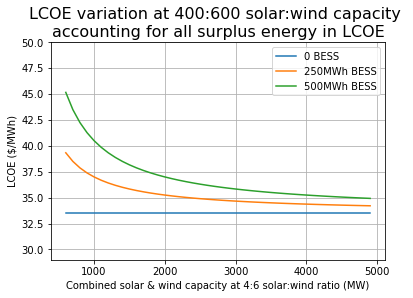

In [234]:
plt.plot(ratio_df0['LCOE'], label = '0 BESS')
plt.plot(ratio_df250['LCOE'], label = '250MWh BESS')
plt.plot(ratio_df500['LCOE'], label = '500MWh BESS')
plt.xlabel('Combined solar & wind capacity at 4:6 solar:wind ratio (MW)')
plt.ylabel('LCOE ($/MWh)')
plt.ylim([29,50])
plt.title('LCOE variation at 400:600 solar:wind capacity \naccounting for all surplus energy in LCOE', fontsize = 16)
plt.legend()
plt.grid()

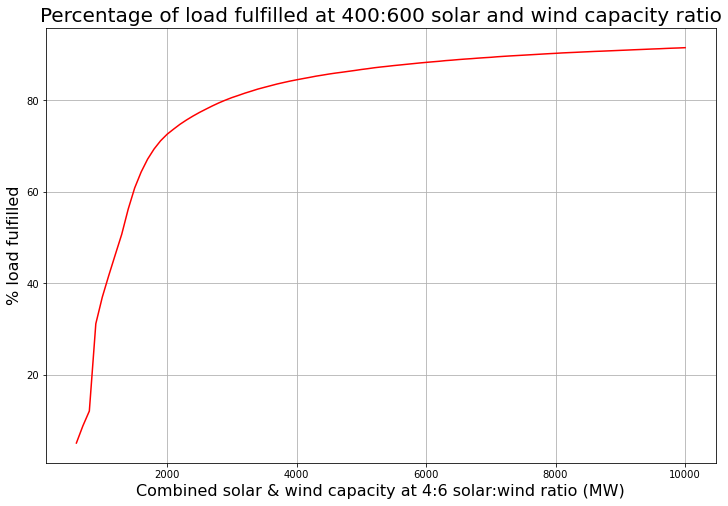

In [198]:
# Plot load as a function of ratio
fig,ax1 = plt.subplots(figsize = [12,8])
# ax2 = ax1.twinx()

ax1.plot(ratio_df.iloc[:,0], label = '% Load', color = 'red')
ax1.set_xlabel('Combined solar & wind capacity at 4:6 solar:wind ratio (MW)', fontsize = 16)
ax1.set_ylabel('% load fulfilled', fontsize = 16)
ax1.set_title('Percentage of load fulfilled at 400:600 solar and wind capacity ratio', fontsize = 20)
#ax1.legend(loc=[0,0.9])
ax1.grid()
plt.savefig('Upscaled wind solar ratio')

# Use if wanting LCOE on graph
# ax2.plot(ratio_df.iloc[:,1], label = 'LCOE')
# ax2.set_ylabel('LCOE ($/MWh)')
# ax2.legend(loc =[0,0.8])

In [104]:
# From previous models runs, stored on my computer
lcoe_comb = xr.open_dataset('Downloads/lcoe_comb.nc')
percent_load_comb = xr.open_dataset('Downloads/percent_load_comb.nc')

lcoe_excess = xr.open_dataset('Downloads/lcoe_comb_with_excess.nc')
excess_gen = xr.open_dataset('Downloads/excess_gen.nc')

lcoe = lcoe_comb.lcoe
percent_load = percent_load_comb.percent_load

lcoe_e = lcoe_excess.lcoe
excess_gen = excess_gen.percent_load # incorrectly named but variable is actually excess_gen

In [179]:
min_lcoe_capped = np.empty([5,57])
load_percent_capped = np.empty(57)

min_lcoe_excess = np.empty([5,57])

for bind, b in enumerate(range(0,500,100)):
    for lind, l in enumerate(range(30,87)):
        lcoe_load_capped = lcoe.sel(battery_capacity = b).where(percent_load.sel(battery_capacity = b)> l)

        load_percent[lind] = l
        min_lcoe_capped[bind,lind] = lcoe_load_capped.where(lcoe_load_capped==lcoe_load_capped.min(),drop=True)
        
for bind, b in enumerate(range(0,500,100)):
    for lind, l in enumerate(range(30,87)):
        lcoe_load_excess = lcoe_e.sel(battery_capacity = b).where(percent_load.sel(battery_capacity = b)> l)

        min_lcoe_excess[bind,lind] = lcoe_load_excess.where(lcoe_load_excess==lcoe_load_excess.min(),drop=True)

In [178]:
load_percent

array([30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42.,
       43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55.,
       56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68.,
       69., 70., 71., 72., 73., 74., 75., 76., 77., 78., 79., 80., 81.,
       82., 83., 84., 85., 51.])

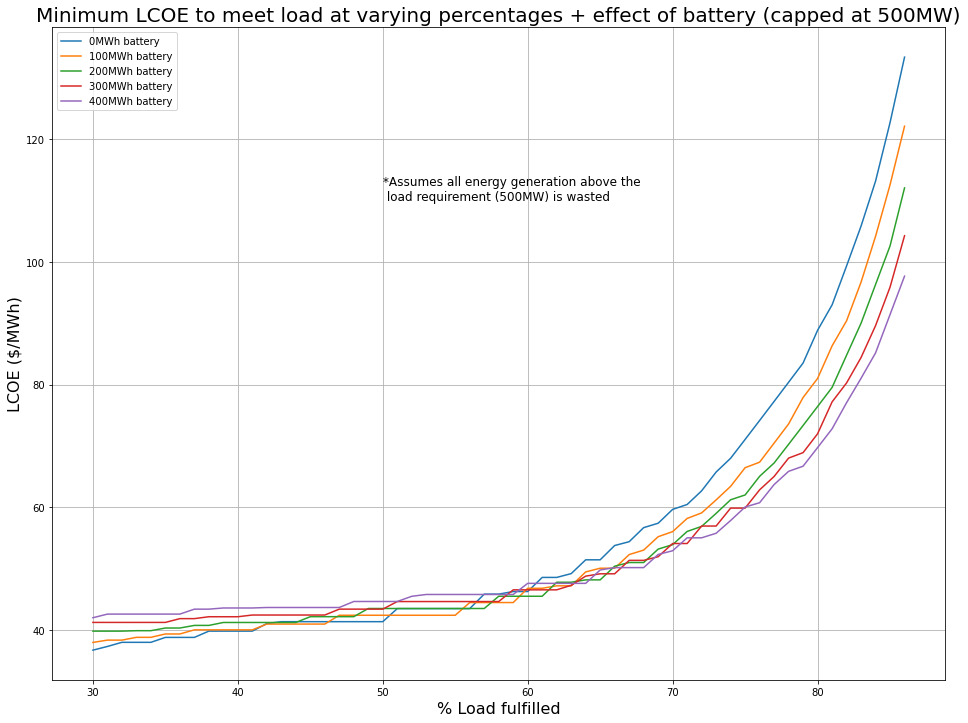

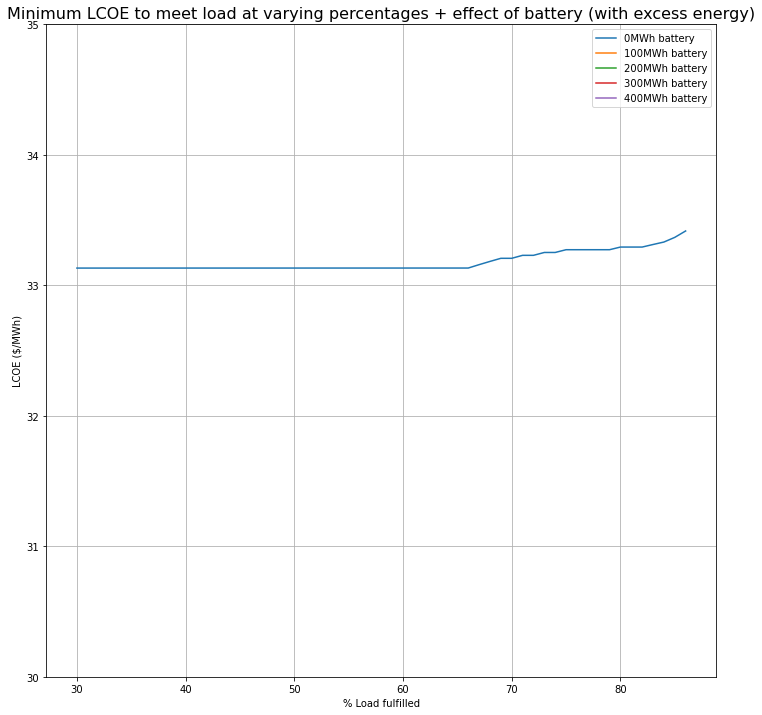

In [202]:
plt.figure(figsize = [16,12])
for index,i in enumerate(range(0,500,100)):
    plt.plot(load_percent,min_lcoe_capped[index], label = str(i) + 'MWh battery')
plt.legend()
plt.ylabel('LCOE ($/MWh)', fontsize = 16)
plt.xlabel('% Load fulfilled', fontsize = 16)
plt.title('Minimum LCOE to meet load at varying percentages + effect of battery (capped at 500MW)', fontsize = 20)
plt.text(50,110,'*Assumes all energy generation above the \n load requirement (500MW) is wasted', fontsize = 12)
plt.grid()
plt.show()

plt.figure(figsize = [12,12])
for index,i in enumerate(range(0,500,100)):
    plt.plot(load_percent,min_lcoe_excess[index], label = str(i) + 'MWh battery')

plt.legend()
plt.ylabel('LCOE ($/MWh)')
plt.xlabel('% Load fulfilled')
plt.title('Minimum LCOE to meet load at varying percentages + effect of battery (with excess energy)', fontsize = 16)
#plt.text(50,110,'*Assumes all energy generation is considered in LCOE')
plt.ylim([30,35])
plt.grid()
plt.show()

In [ ]:
# Gives you the coordinates (wind and solar capacity) of each minimised LCOE for each load percentage
load = 60
lcoe_load = lcoe_e.sel(battery_capacity = 0).where(percent_load.sel(battery_capacity = 0)> load)

lcoe_load.where(lcoe_load==lcoe_load.min(),drop=True)

In [322]:
# To calculate excess generation (doesn't work with the current outputs of the model)

# 500MWh BESS
solar = np.empty(57)
wind = np.empty(57)
excess_gen500 = np.empty(57)

battery_capacity = 500

for index, l in enumerate(range(30,87)):  
    lcoe_load = lcoe.sel(battery_capacity = battery_capacity).where(percent_load.sel(battery_capacity = battery_capacity)> l)

    wind[index] = lcoe_load.where(lcoe_load==lcoe_load.min(),drop=True).wind_capacity
    solar[index] = lcoe_load.where(lcoe_load==lcoe_load.min(),drop=True).solar_capacity
    
    _,_, excess_gen500[index] = sizing_model(wind[index], solar[index], battery_capacity)

# 0 MWh BESS
solar = np.empty(57)
wind = np.empty(57)
excess_gen0 = np.empty(57)

battery_capacity = 0

for index, l in enumerate(range(30,87)):  
    lcoe_load = lcoe.sel(battery_capacity = battery_capacity).where(percent_load.sel(battery_capacity = battery_capacity)> l)

    wind[index] = lcoe_load.where(lcoe_load==lcoe_load.min(),drop=True).wind_capacity
    solar[index] = lcoe_load.where(lcoe_load==lcoe_load.min(),drop=True).solar_capacity
    
    _,_, excess_gen0[index] = sizing_model(wind[index], solar[index], battery_capacity)

Text(0, 0.5, 'Excess generation lost (GWh)')

<Figure size 864x864 with 0 Axes>

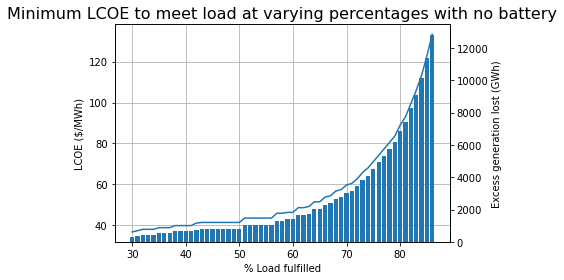

<Figure size 864x864 with 0 Axes>

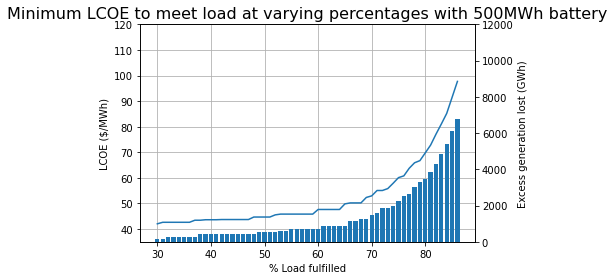

In [328]:
#0MWh battery 
plt.figure(figsize = [12,12])
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(load_percent,min_lcoe[0])
ax1.set_ylabel('LCOE ($/MWh)')
ax1.set_xlabel('% Load fulfilled')
ax1.set_title('Minimum LCOE to meet load at varying percentages with no battery', fontsize = 16)
ax1.grid()

ax2.bar(load_percent,excess_gen0)
ax2.set_ylabel('Excess generation lost (GWh)')

#500MWh battery

plt.figure(figsize = [12,12])
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(load_percent,min_lcoe[4])
ax1.set_ylabel('LCOE ($/MWh)')
ax1.set_xlabel('% Load fulfilled')
ax1.set_title('Minimum LCOE to meet load at varying percentages with 500MWh battery', fontsize = 16)
ax1.set_ylim([35,120])
ax1.grid()

ax2.bar(load_percent,excess_gen500)
ax2.set_ylim([0,12000])
ax2.set_ylabel('Excess generation lost (GWh)')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


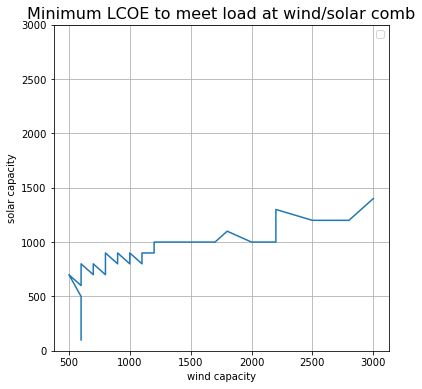

In [268]:
# Related to big LCOE graphs, what is the associated capacity with each percentage?
plt.figure(figsize = [6,6])
plt.plot(wind,solar)
plt.legend()
plt.ylabel('solar capacity')
plt.xlabel('wind capacity')
plt.ylim([0,3000])
plt.title('Minimum LCOE to meet load at wind/solar comb', fontsize = 16)
plt.grid()

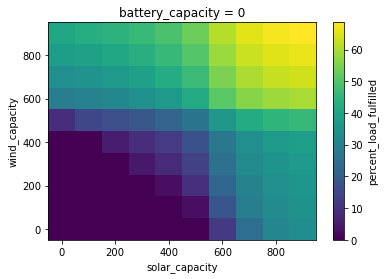

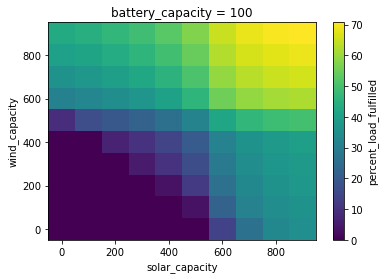

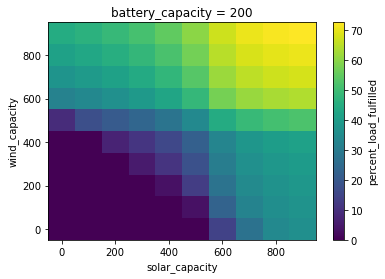

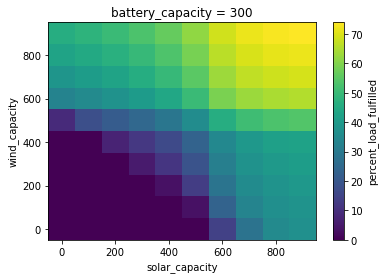

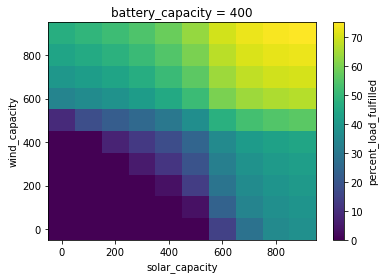

In [282]:
# Experimenting with xarray heat maps to better visualise
for battery in range(0,500,100):
    xr_data.sel(battery_capacity=battery).plot(cbar_kwargs = {'ticks': np.arange(0,80,10)})
    plt.show()